In [1]:
import cv2
import numpy as np

# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.tracking import houghCircle, kernelFind, circularKernelFind, convCircle
from pepe.topology import findPeaks2D

from lmfit import Parameters, minimize, fit_report

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
#%matplotlib

In [2]:
def genTrainingImages(imgSize, N, minCircles=1, maxCircles=4, minRadius=125, maxRadius=200, overlap=False, noise=1):
    img = np.zeros((N, *imgSize))
    numCircles = np.random.randint(minCircles, maxCircles, size=N)
    
    circleCentersX = np.random.randint(0, imgSize[0], size=N)
    circleCentersY = np.random.randint(0, imgSize[1], size=N)
    
    Y = np.arange(imgSize[0]).reshape((imgSize[0], 1)) # Column vector
    X = np.arange(imgSize[1]).reshape((1, imgSize[1])) # Row vector
    
    # Generate the circles
    for i in range(N):
        radii = np.random.uniform(minRadius, maxRadius, size=numCircles[i])
        j = 0
        while j < numCircles[i]:
            yC, xC = np.random.randint(0, imgSize[0]), np.random.randint(0, imgSize[1])
            newCircle = ((X - xC)**2 + (Y - yC)**2) < radii[j]**2
            # Make sure circles don't overlap
            if np.max(img[i] + newCircle) == 1:
                img[i] += newCircle
                j += 1
                print((yC, xC))
                
    # Now add noise
    noisyImg = img + np.random.uniform(0.01*noise, noise, size=img.shape)
    
    return noisyImg, img, (yC, xC)

In [3]:
# The function we will be fitting
def cone(p, center, halfAngle, offset, roundness):
    d = np.sqrt((center[0] - p[0])**2 + (center[1] - p[1])**2)
    return offset - d/np.tan(halfAngle) * np.exp(-(roundness)**2/d)

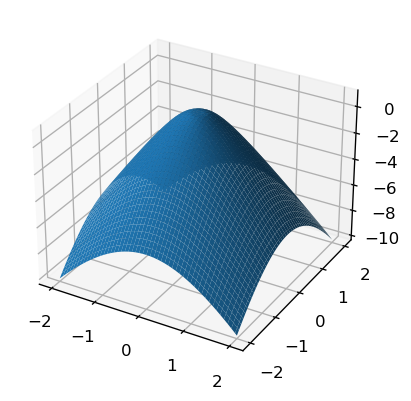

In [4]:
s = 100
xArr = np.linspace(-2, 2, s)

coneArr = np.zeros((s, s))

for i in range(s):
    for j in range(s):
        coneArr[i,j] = cone((xArr[i],xArr[j]), (0,0), .2, 1, .8)

ax = plt.subplot(projection='3d')
ax.plot_surface(xArr, np.vstack(xArr), coneArr)
plt.show()

In [11]:
radius = 150

noisyImg, img, center = genTrainingImages((1024, 1280), 1, minCircles=1, maxCircles=3,
                                          noise=10, minRadius=radius, maxRadius=radius)

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(img[0])
ax[1].imshow(noisyImg[0])
plt.show()

(788, 245)
(446, 532)


In [12]:
convCircle(noisyImg[0], radius, minPeakPrevalence=.7)

[(788, 245), (446, 532)]

In [13]:
convArr = circularKernelFind(noisyImg[0], radius, debug=True, fftPadding=int(2.5*radius))

peakDownsample = 10
downsampledConvArr = cv2.resize(cv2.blur(np.abs(convArr), (peakDownsample,peakDownsample)),
                                     (0,0), fx=1/peakDownsample, fy=1/peakDownsample, interpolation=cv2.INTER_CUBIC)

In [14]:
%matplotlib
ax = plt.subplot(projection='3d')
ax.plot_surface(np.arange(downsampledConvArr.shape[1]),
                np.vstack(np.arange(downsampledConvArr.shape[0])), downsampledConvArr)
plt.show()

Using matplotlib backend: QtAgg


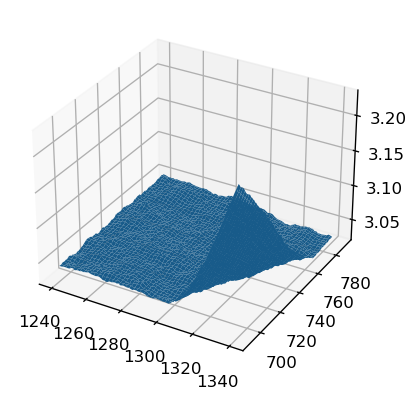

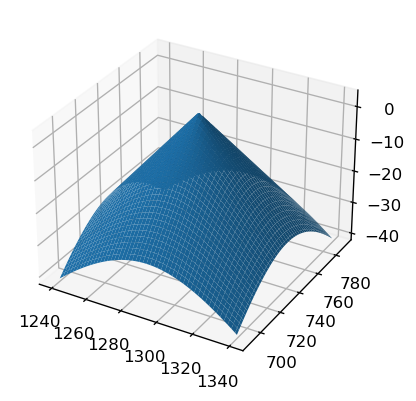

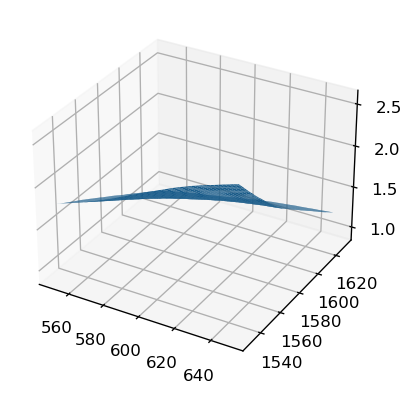

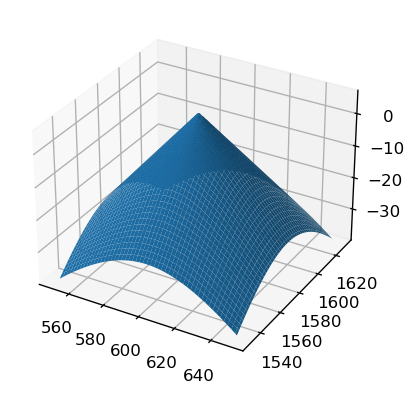

In [37]:
padding = 50
maxEvals = 100

peakPositions, peakPrevalences = findPeaks2D(downsampledConvArr, minPeakPrevalence=.6)

# Get rid of the downsample factor
peakPositions = [(int(peakPositions[i][0]*peakDownsample), int(peakPositions[i][1]*peakDownsample)) for i in range(len(peakPositions))]

def objectiveFunction(params, padding, trueImage):
    center = (params["centerX"], params["centerY"])
    angle = params["angle"]
    roundness = params["roundness"]
    offset = params["offset"]
    
    leftRightBounds = np.int16([max(center[0] - padding, 0), min(center[0] + padding, trueImage.shape[1])])
    topBottomBounds = np.int16([max(center[1] - padding, 0), min(center[1] + padding, trueImage.shape[0])])
    
    dim = (leftRightBounds[1] - leftRightBounds[0], topBottomBounds[1] - topBottomBounds[0])
    xArr = np.linspace(leftRightBounds[0], leftRightBounds[1], dim[1])
    yArr = np.linspace(topBottomBounds[0], topBottomBounds[1], dim[0])

    clippedImage = trueImage[leftRightBounds[0]:leftRightBounds[1], topBottomBounds[0]:topBottomBounds[1]]

    coneArr = np.zeros((dim[1], dim[0]))
    for i in range(dim[1]):
        for j in range(dim[0]):
            coneArr[i,j] = cone((yArr[i],xArr[j]), center, angle, offset, roundness)

    return np.sum(np.abs(coneArr - clippedImage))
        
for i in range(len(peakPositions)):
    params = Parameters()

    params.add('centerX', value=peakPositions[i][1], min=peakPositions[i][1]-padding, max=peakPositions[i][1]+padding)
    params.add('centerY', value=peakPositions[i][0], min=peakPositions[i][0]-padding, max=peakPositions[i][0]+padding)
    params.add('angle', value=.2, min=.01, max=1.)
    params.add('roundness', .2, min=0., max=3.)
    params.add('offset', value=convArr[peakPositions[i]], max=np.max(convArr), min=np.min(convArr))
    
    # Now do the optimization
    result = minimize(objectiveFunction, params,
                     args=(padding, convArr),
                     method='nelder', nan_policy='omit', max_nfev=maxEvals)
    
    center = (result.params["centerX"], result.params["centerY"])
    angle = result.params["angle"]
    roundness = result.params["roundness"]
    offset = result.params["offset"]
    
    leftRightBounds = np.int16([max(center[1] - padding, 0), min(center[1] + padding, convArr.shape[1])])
    topBottomBounds = np.int16([max(center[0] - padding, 0), min(center[0] + padding, convArr.shape[0])])
    
    dim = (topBottomBounds[1] - topBottomBounds[0], leftRightBounds[1] - leftRightBounds[0])
    xArr = np.linspace(leftRightBounds[0], leftRightBounds[1], dim[1])
    yArr = np.linspace(topBottomBounds[0], topBottomBounds[1], dim[0])

    clippedImage = convArr[topBottomBounds[0]:topBottomBounds[1], leftRightBounds[0]:leftRightBounds[1]]

    coneArr = np.zeros((dim[0], dim[1]))
    for i in range(dim[0]):
        for j in range(dim[1]):
            coneArr[i,j] = cone((yArr[i],xArr[j]), center, angle, offset, roundness)

    ax = plt.subplot(projection='3d')
    #ax.plot_surface(np.arange(dim[1]),
    #                np.vstack(np.arange(dim[0])), clippedImage)
    ax.plot_surface(xArr,
                    np.vstack(yArr), clippedImage)

    plt.show()
    
    ax = plt.subplot(projection='3d')
    ax.plot_surface(xArr,
                    np.vstack(yArr), coneArr)
    plt.show()
#    ax = plt.subplot(projection='3d')
#    ax.plot_surface(np.arange(clippedPeak.shape[0]),
#                    np.vstack(np.arange(clippedPeak.shape[1])), clippedPeak)
#    plt.show()

In [36]:
result